# Cell 1 - Markdown
# 02 – Model Training

In this notebook, we train a Random Forest classifier on the prepared German Credit Risk dataset.  
We log the model and key parameters using MLflow for tracking and reproducibility.

In [1]:
# Cell 1 - Load data and compute correlations with proxy target

import pandas as pd
from pathlib import Path

# Define the path to the CSV file relative to the notebook (one level up from 'notebooks/')
project_root = Path.cwd().parent
csv_path = project_root / "data" / "credit.csv"

# Load the dataset
df = pd.read_csv(csv_path)

# Standardize column names: strip spaces, remove hyphens, and capitalize consistently
df.columns = df.columns.str.strip().str.replace(" ", "").str.replace("-", "").str.capitalize()

# Create a proxy target variable if not already present
# Default = 1 if CreditAmount > 5000 and Duration > 24 months
df["Default"] = ((df["Creditamount"] > 5000) & (df["Duration"] > 24)).astype(int)

# Select only numerical columns (including 'Default')
numerical_df = df.select_dtypes(include=["number"])

# Compute correlation of numerical features with 'Default'
correlations = numerical_df.corr(numeric_only=True)["Default"].sort_values(ascending=False)

# Output correlations
print("Correlation of numerical features with 'Default':")
print(correlations)

Correlation of numerical features with 'Default':
Default         1.000000
Creditamount    0.712551
Duration        0.651003
Job             0.171398
Age             0.007017
Unnamed:0      -0.007473
Name: Default, dtype: float64


In [2]:
# Cell 2 - Code: Imports and setup
import os
import mlflow
import joblib
from sklearn.ensemble import RandomForestClassifier

os.chdir("..")

mlruns_path = os.path.abspath("mlruns").replace("\\", "/")
mlflow.set_tracking_uri(f"file:///{mlruns_path}")
mlflow.set_experiment("SecureML Credit Model")

from src.data_loader import load_and_preprocess_data

In [3]:
# Cell 3 - Code: Load preprocessed data
import os

# Wechsle in den Projektordner
os.chdir(r"C:\Users\eren_\OneDrive\Desktop\secureML-audit-framework")
print("Current working directory:", os.getcwd())

data_path = os.path.abspath("data/credit.csv").replace("\\", "/")
print("Using data file:", data_path)

X_train, X_test, y_train, y_test = load_and_preprocess_data(path=data_path)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Current working directory: C:\Users\eren_\OneDrive\Desktop\secureML-audit-framework
Using data file: C:/Users/eren_/OneDrive/Desktop/secureML-audit-framework/data/credit.csv
Training data shape: (800, 9)
Test data shape: (200, 9)


In [4]:
# Cell 4 - Code: Train model and log with MLflow
import os

def train_model(X_train, y_train):
    with mlflow.start_run():
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Log model with input example to avoid warnings
        mlflow.sklearn.log_model(
            model, 
            "model", 
            input_example=X_train.iloc[:5] if hasattr(X_train, "iloc") else X_train[:5]
        )
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("model_type", "RandomForest")

        # Ensure 'models' directory exists
        os.makedirs("models", exist_ok=True)
        # Save model locally
        joblib.dump(model, "models/rf_model.joblib")

    return model

model = train_model(X_train, y_train)
print("Model trained and logged successfully.")

2025/06/29 17:07:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\eren_\OneDrive\Desktop\secureML-audit-framework\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model trained and logged successfully.


In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score
import numpy as np

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Stratified K-Fold sorgt für gleichmäßige Klassenverteilung in den Folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy
acc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# F1-Score (binary)
f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

# ROC AUC (nur für binäre Klassifikation)
roc_auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"CV Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
print(f"CV F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"CV ROC AUC: {np.mean(roc_auc_scores):.3f} ± {np.std(roc_auc_scores):.3f}")

CV Accuracy: 0.999 ± 0.002
CV F1 Score: 0.999 ± 0.002
CV ROC AUC: 1.000 ± 0.000


In [6]:
# Cell 5 - Code: Train model and log with MLflow
from sklearn.ensemble import RandomForestClassifier
import joblib
import mlflow.sklearn
import os

# Stelle sicher, dass Ordner zum Speichern existiert
os.makedirs("models", exist_ok=True)

def train_model(X_train, y_train):
    with mlflow.start_run():
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Logge Modell, Parameter und Typ
        mlflow.sklearn.log_model(model, artifact_path="model")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("model_type", "RandomForest")

        # Speichere lokal
        joblib.dump(model, "models/rf_model.joblib")
    
    print("Model trained and logged successfully.")
    return model

# Modell trainieren
model = train_model(X_train, y_train)

2025/06/29 17:07:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/29 17:07:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model trained and logged successfully.


Accuracy: 1.0000
ROC-AUC Score: 1.0000
Precision-Recall AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       141

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



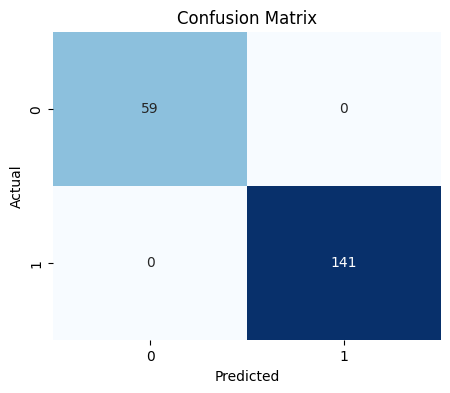

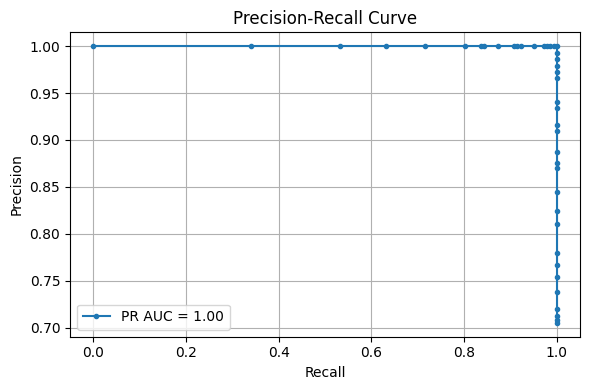

In [7]:
# Cell 6 - Code: Extended Model Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    auc
)

# Vorhersagen
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Metriken
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()